# Categorical Embedding

## Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import chain
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.metrics import top_k_categorical_accuracy
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Embedding,Reshape, Concatenate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

## Data

In [18]:
data = pd.read_csv("./data/splited_full_RASFF_DATA.csv", sep=";", header=0, index_col=0)
data = data.sample(frac=1)

data.head(1)

,DATE_CASE,NOT_COUNTRY,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN
96786,2012-11-28,Slovenia,fruits and vegetables,food,not serious,informing recipient(s),distribution to other member countries,metals,Germany,Austria,


In [19]:
class Stage:
	def __init__(self, input, output):
		self.input = input
		self.output = output

		self.x = data.iloc[:, input]
		self.y = data.iloc[:, output]

		self.x_train, self.y_train = None, None
		self.x_val, self.y_val = None, None
		self.x_test, self.y_test = None, None

		self.input_list_train, self.input_list_test, self.input_list_testval = None, None, None

		self.__transform()

	def __transform(self):
		strategy = OneHotEncoder(handle_unknown="ignore", sparse=False)
		strategy.fit(self.y.values)

		self.y = strategy.transform(self.y.values)

		self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.2)
		self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.25, random_state=42,shuffle = True)

	def get_metrics(self):
		result = model.predict(self.input_list_test, batch_size=64)
		result = np.argmax(result, axis=-1)

		print(f"- Accuracy: {round(accuracy_score(np.argmax(self.y_test, axis=-1), result)*100, 2)}%")
		print(f"- Specifity: {round(get_specifity(np.argmax(self.y_test, axis=-1), result)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(np.argmax(self.y_test, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precision: {round(precision_score(np.argmax(self.y_test, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")

		print(classification_report(np.argmax(self.y_test, axis=-1), result, zero_division=True))

		cm = confusion_matrix(np.argmax(self.y_test, axis=-1), result)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0, cm.shape[0])))

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

		plt.show()

## Preprocessing

In [20]:
data.DATE_CASE = data.DATE_CASE.astype(str)
data.HAZARDS_CAT = data.HAZARDS_CAT.astype(str)
data.COUNT_DESTIN = data.COUNT_DESTIN.astype(str)
data.COUNT_CONCERN = data.COUNT_CONCERN.astype(str)

data = data.dropna(subset=['DATE_CASE'])

# data.dropna(subset=data.columns[[1, 3, 5, 8, 9, 12, 13]], inplace=True)

In [21]:
def preproc(X_train, X_test, X_val):
    input_list_train = []
    input_list_test = []
    input_list_testval = []
    
    for c in stage1.x.columns:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        input_list_testval.append(X_val[c].map(val_map).fillna(0).values)

    return input_list_train, input_list_test,input_list_testval

In [22]:
def get_specifity(y_actual, y_pred):
    TN = []
    FP = []

    for index ,_id in enumerate(np.union1d(y_actual, y_pred)):
        FP.append(0)
        TN.append(0)

        for i in range(len(y_pred)):
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1

    TN = sum(TN)
    FP = sum(FP)

    return TN/(TN + FP)

## Transformation

In [7]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

lens = data['HAZARDS_CAT'].str.split(',').map(len)
split1 = pd.DataFrame({'DATE_CASE': np.repeat(data['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(data['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(data['PROD_CAT'], lens),
                    'TYPE': np.repeat(data['TYPE'], lens),
                    'RISK_DECISION': np.repeat(data['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(data['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(data['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': chainer(data['HAZARDS_CAT']),
                    'COUNT_ORIGEN': np.repeat(data['COUNT_ORIGEN'], lens),
                    'COUNT_DESTIN': np.repeat(data['COUNT_DESTIN'], lens),
                    'COUNT_CONCERN': np.repeat(data['COUNT_CONCERN'], lens)})

lens = split1['COUNT_ORIGEN'].str.split(',').map(len)
split2 = pd.DataFrame({'DATE_CASE': np.repeat(split1['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(split1['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(split1['PROD_CAT'], lens),
                    'TYPE': np.repeat(split1['TYPE'], lens),
                    'RISK_DECISION': np.repeat(split1['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(split1['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(split1['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': np.repeat(split1['HAZARDS_CAT'], lens),
                    'COUNT_ORIGEN': chainer(split1['COUNT_ORIGEN']),
                    'COUNT_DESTIN': np.repeat(split1['COUNT_DESTIN'], lens),
                    'COUNT_CONCERN': np.repeat(split1['COUNT_CONCERN'], lens)})

lens = split2['COUNT_DESTIN'].str.split(',').map(len)
split3 = pd.DataFrame({'DATE_CASE': np.repeat(split2['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(split2['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(split2['PROD_CAT'], lens),
                    'TYPE': np.repeat(split2['TYPE'], lens),
                    'RISK_DECISION': np.repeat(split2['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(split2['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(split2['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': np.repeat(split2['HAZARDS_CAT'], lens),
                    'COUNT_ORIGEN': np.repeat(split2['COUNT_ORIGEN'], lens),
                    'COUNT_DESTIN': chainer(split2['COUNT_DESTIN']),
                    'COUNT_CONCERN': np.repeat(split2['COUNT_CONCERN'], lens)})

lens = split3['COUNT_CONCERN'].str.split(',').map(len)
split4 = pd.DataFrame({'DATE_CASE': np.repeat(split3['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(split3['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(split3['PROD_CAT'], lens),
                    'TYPE': np.repeat(split3['TYPE'], lens),
                    'RISK_DECISION': np.repeat(split3['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(split3['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(split3['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': np.repeat(split3['HAZARDS_CAT'], lens),
                    'COUNT_ORIGEN': np.repeat(split3['COUNT_ORIGEN'], lens),
                    'COUNT_DESTIN': np.repeat(split3['COUNT_DESTIN'], lens),
                    'COUNT_CONCERN': chainer(split3['COUNT_CONCERN'])})

split4 = split4.reset_index(drop = True)
split4 = split4.dropna(subset = ['DATE_CASE'])

data = split4.copy()

In [23]:
data.head(1)

,DATE_CASE,NOT_COUNTRY,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN
96786,2012-11-28,Slovenia,fruits and vegetables,food,not serious,informing recipient(s),distribution to other member countries,metals,Germany,Austria,


## Data Mining

In [24]:
stage1 = Stage(
	input=[0, 1, 6, 8],
	output=[2]
)

In [25]:
def top_1_categorical_accuracy(y_true, y_pred):
	return top_k_categorical_accuracy(y_true, y_pred, k=1)

def top_2_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [26]:
input_models = []
output_embeddings = []

for categorical_var in stage1.x.columns:
    cat_emb_name = categorical_var.replace(" ", "") + "_Embedding"
    input_name = "Input_" + categorical_var.replace(" ", "")
    no_of_unique_cat = stage1.x_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50))
   
    input_model = Input(shape=(1, ), name=input_name)
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size, ))(output_model)    
    
    input_models.append(input_model)
    output_embeddings.append(output_model)
  
output = Concatenate()(output_embeddings)
output = Dense(2048,activation="relu")(output)
output = Dropout(0.3)(output)
output = Dense(1024,activation="relu")(output)
output = Dropout(0.2)(output)
output = Dense(512,activation="relu")(output)
output = Dropout(0.2)(output)
output = Dense(43, activation="softmax")(output)

model = Model(inputs=input_models, outputs=output)

In [27]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_DATE_CASE (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_NOT_COUNTRY (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_DISTRIBUTION_STAT (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_COUNT_ORIGEN (InputLayer) [(None, 1)]          0                                            
____________________________________________________________________________________________

In [29]:
stage1.input_list_train, stage1.input_list_test, stage1.input_list_testval = preproc(stage1.x_train, stage1.x_test, stage1.x_val)

hist = model.fit(stage1.input_list_train, stage1.y_train, validation_data=(stage1.input_list_testval, stage1.y_val), epochs=5, batch_size=64, verbose=1)

Epoch 1/5
1577/1577 [==============================] - 64s 39ms/step - loss: 1.6778 - accuracy: 0.5535 - top_1_categorical_accuracy: 0.5535 - top_2_categorical_accuracy: 0.6613 - top_3_categorical_accuracy: 0.7232 - val_loss: 1.2327 - val_accuracy: 0.6691 - val_top_1_categorical_accuracy: 0.6691 - val_top_2_categorical_accuracy: 0.7653 - val_top_3_categorical_accuracy: 0.8140
Epoch 2/5
1577/1577 [==============================] - 67s 43ms/step - loss: 1.0392 - accuracy: 0.7198 - top_1_categorical_accuracy: 0.7198 - top_2_categorical_accuracy: 0.8115 - top_3_categorical_accuracy: 0.8550 - val_loss: 1.0113 - val_accuracy: 0.7299 - val_top_1_categorical_accuracy: 0.7299 - val_top_2_categorical_accuracy: 0.8171 - val_top_3_categorical_accuracy: 0.8581
Epoch 3/5
1577/1577 [==============================] - 59s 38ms/step - loss: 0.7547 - accuracy: 0.7911 - top_1_categorical_accuracy: 0.7911 - top_2_categorical_accuracy: 0.8693 - top_3_categorical_accuracy: 0.9037 - val_loss: 0.9169 - val_acc

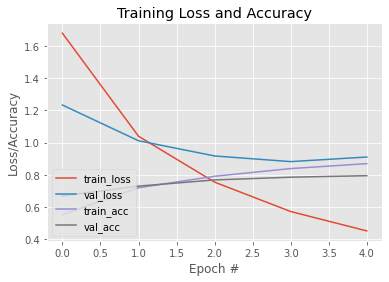

In [30]:
plt.style.use("ggplot")

plt.figure()

plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

- Accuracy: 79.09%
- Specifity: 99.37%
- Sensitivity: 66.74%
- Precision: 71.37%
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       102
           1       1.00      0.00      0.00         6
           2       0.64      0.70      0.67       183
           3       0.78      0.63      0.69       564
           4       0.69      0.42      0.52       170
           5       0.80      0.76      0.78      1714
           6       0.81      0.80      0.81       756
           7       0.92      0.76      0.84       203
           8       0.74      0.79      0.77       708
           9       0.69      0.61      0.65       761
          10       0.92      0.93      0.93      3832
          11       0.91      0.80      0.85       335
          12       0.44      0.71      0.54        24
          13       0.86      0.75      0.80        16
          14       0.88      0.88      0.88       568
          15       0.92      0.92      0.92       271


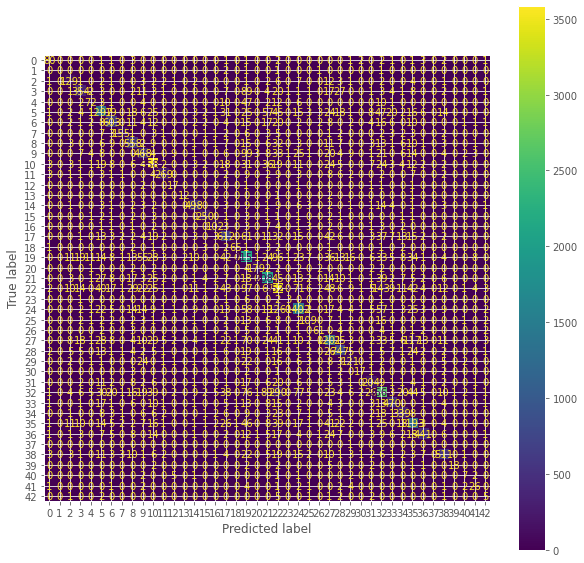

In [31]:
stage1.get_metrics()

In [32]:
historials = []
evaluations = []

for i in range (1, 6):
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", top_1_categorical_accuracy, top_2_categorical_accuracy, top_3_categorical_accuracy])
    
    hist = model.fit(stage1.input_list_train, stage1.y_train, validation_data=(stage1.input_list_testval, stage1.y_val), epochs=25, batch_size=64, verbose=0)
    historials.append(hist)
    
    evaluation = model.evaluate(x=stage1.input_list_test, y=stage1.y_test)
    evaluations.append(evaluation)
    
    model.save("model" + str(i) + ".h5")

    stage1.get_metrics()

    print("\n\n-----------------------\n")

KeyboardInterrupt: 